# Colonia de Hormigas
El objetivo de esta práctica es estudiar el funcionamiento de los Algoritmos de Optimización Basados en Colonias de Hormigas (OCH). Para ello, se requerirá que el alumno implemente distintas variantes de estos algoritmos, correspondientes al Sistema de Hormigas (SH) y Sistema de Hormigas Elitista (SHE)), para resolver el problema del Viajante de Comercio. El comportamiento de los algoritmos de OCH implementados deberá compararse con un algoritmo greedy.

## Problema
El Problema del Viajante de Comercio (TSP) es uno de los problemas de optimización combinatoria más conocidos. En su formulación más general, dadas una serie de ciudades, el objetivo consiste en encontrar el circuito de menor coste que parta de una ciudad concreta, pase por todas las demás una sola vez y retorne a la ciudad de origen.

En nuestro caso trabajaremos con instancias estándar del problema (dos data sets modelo), obtenidas de la biblioteca TSPLIB, todas ellas correspondientes al TSP simétrico. Éstas son: • C130 Tamaño 130 ciudades. Coste de la solución óptima: 6.110 • A280 Tamaño 280 ciudades. Coste de la solución óptima: 2.579

Todos estos ficheros presentan el mismo formato, una lista con dos valores para cada ciudad que representan sus coordenadas en el plano. Para componer la matriz de costes se deberá calcular la distancia euclídea entre cada par de ciudades (i, j). Los costos obtenidos han de ser números enteros, es decir, no se considerarán decimales. Así, la matriz de distancias se calcularía de la siguiente forma:
xd = x[i] - x[j];
yd = y[i] - y[j];
dij = rint( sqrt( xdxd + ydyd ) );

donde rint es la función de redondeo y sqrt es la raíz cuadrada.

El alumno implementará el SH (Sistema de Hormigas) y SHE (Sistema de Hormigas Elitista) para resolver el problema, con los distintos data sets.

## Librerías

In [1]:
import random
import numpy as np
import copy

# Graphs and Plots
import matplotlib.pyplot as plt
from PIL import Image

import statistics

import pandas as pd

import os

import math

import time
import timeit

# Barra de progreso
from tqdm import tqdm

## Parámetros

### Semillas

In [2]:
# Establecer semillas

semilla_1 = 9244889
semilla_2 = 6885052
semilla_3 = 1689685
semilla_4 = 2674794
semilla_5 = 3656827

semillas = [semilla_1, semilla_2, semilla_3, semilla_4, semilla_5]

### Algoritmos

In [3]:
greedy_name = "Greedy"
sh_name = "Sistema de Hormigas"
she_name = "Sistema de Hormigas Elitista"

### Parámetros problema

In [4]:
n_hormigas = 30

tiempo_max_c130 = 3 * 60
tiempo_max_a280 = 8 * 60

alpha = 1
beta = 2

n_elitistas = 15

parametro_evaporacion = 0.1

cantidad_feronoma_0 = 0 # 1 / (n · L)
# τ0 = 1 / (n · L), siendo n el tamaño de la instancia del problema y L el coste del circuito devuelto por la heurística greedy implementada.

## Funciones auxiliares

### Leer fichero
La función recibe el nombre del archivo que contiene los datos del TSP y devuelve una lista de coordenadas para cada ciudad.

In [5]:
def cargar_datos(nombre_archivo):
    with open(nombre_archivo) as archivo:
        lineas = archivo.readlines()

    num_ciudades = int(lineas[3].split()[1])
    datos_ciudades = []
    for i in range(6, 6 + num_ciudades):
        ciudad_actual = list(map(float, lineas[i].split()[1:]))
        datos_ciudades.append(ciudad_actual)

    return datos_ciudades

### Leer fichero camino optimo


In [6]:
def leer_path_optimo(file_name):
    with open(file_name, 'r') as f:
        lines = f.readlines()

    path = []
    start = False
    for line in lines:
        if line.startswith("TOUR_SECTION"):
            start = True
            continue
        elif line.startswith("-1"):
            break
        elif start:
            for value in map(int, line.strip().split()):
                if isinstance(value, int):
                    path.append(value-1)

    return path

### Calcular matriz de distancias
La función recibe la lista de coordenadas para cada ciudad y devuelve la matriz de distancias. En este caso, se utiliza la función round para redondear la distancia calculada al número entero más cercano.

In [7]:
def calcular_distancias(datos_ciudades):
    num_ciudades = len(datos_ciudades)
    distancias = [[0] * num_ciudades for _ in range(num_ciudades)]
    for i in range(num_ciudades):
        for j in range(i+1, num_ciudades):
            xd = datos_ciudades[i][0] - datos_ciudades[j][0]
            yd = datos_ciudades[i][1] - datos_ciudades[j][1]
            dij = int(round(math.sqrt(xd*xd + yd*yd)))
            distancias[i][j] = dij
            distancias[j][i] = dij
    return distancias

### Coste Camino

In [8]:
def coste_camino(camino, distancias):
    coste = 0
    for i in range(len(camino)-1):
        coste += distancias[camino[i]][camino[i+1]]
    # Suma la distancia de vuelta a la ciudad inicial
    # coste += distancias[camino[-1]][camino[0]]
    return coste

### Mostrar mapa

In [9]:
import matplotlib.pyplot as plt

def representar_mapa(coordinates, path, algorithm_name, fichero_name, semilla = ""):
    # Crear la figura y los ejes de Matplotlib
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_title(algorithm_name + " (fichero: " + fichero_name + ", semilla: " + str(semilla) + ")")

    # Dibujar las ciudades y la ruta inicial
    x, y = zip(*coordinates)
    ax.plot(x, y, 'o', color='black')
    ax.plot([coordinates[path[0]][0]], [coordinates[path[0]][1]], 'o', color='red')
    ax.plot([coordinates[path[-1]][0]], [coordinates[path[-1]][1]], 'o', color='red')
    ax.annotate("Inicio", xy=(coordinates[path[0]][0], coordinates[path[0]][1]), xytext=(coordinates[path[0]][0]+5, coordinates[path[0]][1]+5), color='red')
    ax.annotate("Fin", xy=(coordinates[path[-1]][0], coordinates[path[-1]][1]), xytext=(coordinates[path[-1]][0]+5, coordinates[path[-1]][1]+5), color='red')

    for i in range(len(path)-1):
        ax.plot([coordinates[path[i]][0], coordinates[path[i+1]][0]],
                [coordinates[path[i]][1], coordinates[path[i+1]][1]],
                '-', color='black')

    # Guardar la figura en formato png
    fig.savefig(algorithm_name + '/' + algorithm_name + " " + fichero_name + " " + str(semilla) + '.png')

    # Mostrar la figura
    plt.show()

## Soluciones Óptimas

### C130

Mejor camino:  [0, 40, 38, 116, 111, 114, 27, 61, 104, 127, 15, 44, 4, 10, 75, 108, 60, 128, 123, 63, 68, 85, 87, 25, 6, 96, 69, 106, 126, 103, 42, 33, 16, 30, 26, 18, 99, 14, 28, 23, 115, 94, 78, 86, 11, 80, 102, 76, 93, 88, 109, 97, 67, 62, 47, 24, 112, 31, 35, 83, 118, 110, 122, 100, 81, 56, 8, 55, 64, 51, 74, 73, 98, 72, 91, 37, 105, 52, 119, 57, 48, 71, 90, 5, 101, 9, 13, 66, 12, 95, 121, 54, 59, 50, 41, 43, 92, 36, 21, 46, 39, 22, 32, 20, 125, 120, 77, 65, 84, 124, 89, 58, 29, 82, 2, 113, 107, 7, 17, 45, 79, 117, 19, 3, 34, 53, 1, 49, 129, 70]


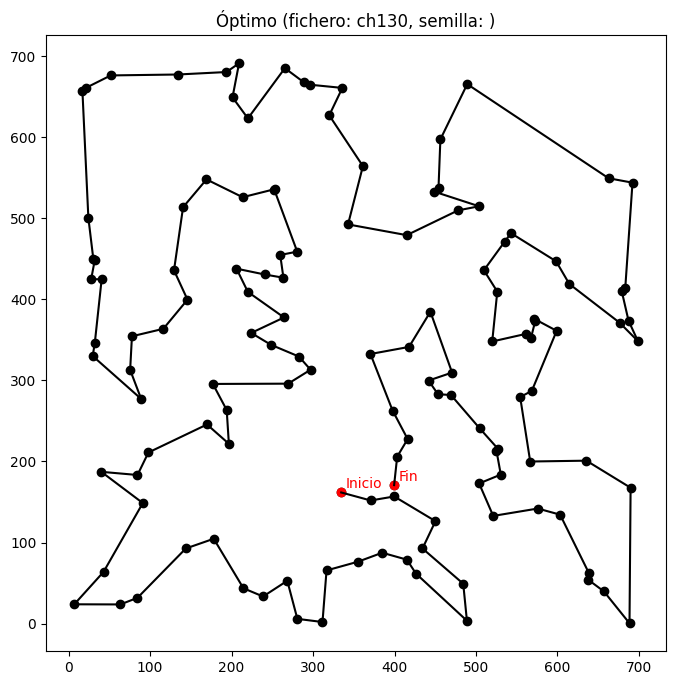

In [10]:
fichero_name = "ch130"
fichero = 'tsp/' + fichero_name + '.tsp'
datos_ciudades = cargar_datos(fichero)
path = leer_path_optimo("tsp/" + fichero_name + ".opt.tour")
print("Mejor camino: ", path)
representar_mapa(datos_ciudades, path, "Óptimo", fichero_name)

### a280

Mejor camino:  [0, 1, 241, 242, 243, 240, 239, 238, 237, 236, 235, 234, 233, 232, 231, 230, 245, 244, 246, 249, 250, 229, 228, 227, 226, 225, 224, 223, 222, 221, 220, 219, 218, 217, 216, 215, 214, 213, 212, 211, 210, 209, 206, 205, 204, 203, 202, 201, 200, 197, 196, 195, 194, 193, 192, 191, 190, 189, 188, 187, 186, 185, 184, 183, 182, 181, 180, 175, 179, 178, 149, 177, 176, 150, 151, 155, 152, 154, 153, 128, 129, 130, 19, 20, 127, 126, 125, 124, 123, 122, 121, 120, 119, 118, 156, 157, 158, 159, 174, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 171, 170, 172, 173, 106, 105, 104, 103, 102, 101, 100, 99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 108, 107, 109, 110, 111, 87, 86, 112, 113, 114, 116, 115, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 58, 62, 61, 117, 60, 59, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 21, 24, 22, 23, 13, 14, 12, 11, 10,

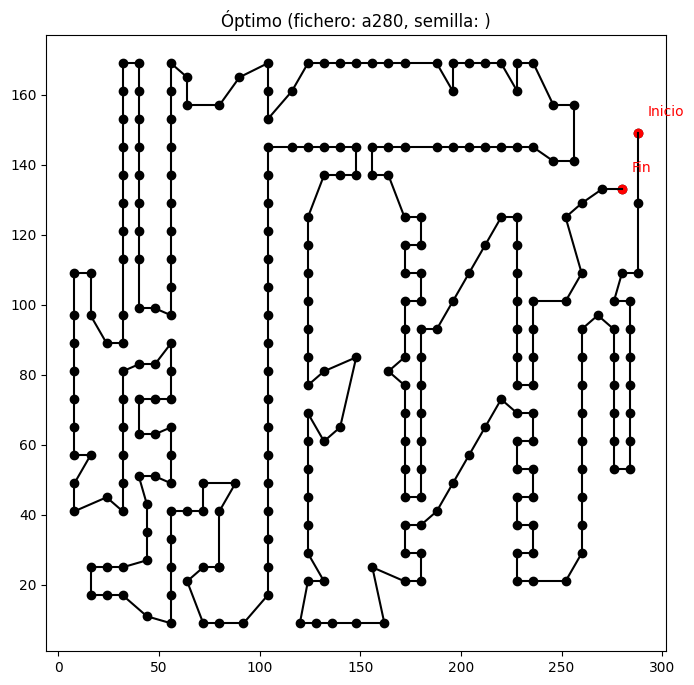

In [11]:
fichero_name = "a280"
fichero = 'tsp/' + fichero_name + '.tsp'
datos_ciudades = cargar_datos(fichero)
path = leer_path_optimo("tsp/" + fichero_name + ".opt.tour")
print("Mejor camino: ", path)
representar_mapa(datos_ciudades, path, "Óptimo", fichero_name)

## Algoritmos de Heurísticas Constructivas
Heurísticas Constructivas: Parten de una solución inicial vacía y van añadiéndole componentes hasta construir una solución.

Las heurísticas constructivas son más rápidas pero dan soluciones de peor calidad que la búsqueda local (BL).

Ambos son procesos de búsqueda efectuados sobre un espacio de soluciones al problema. En los métodos constructivos, el espacio es de soluciones parciales, mientras que en la BL es de soluciones completas (candidatas).

El espacio de búsqueda suele ser de un tamaño exponencial con respecto al tamaño del problema.

### Greedy

In [12]:
def greedy(datos_ciudades, distancias):
    start_time = time.time()
    n_evaluaciones = 0

    n = len(distancias)
    visited = [False] * n
    path = [0]
    visited[0] = True
    coste = 0

    for i in range(1,n):
        last_city = path[-1]
        min_distance = float('inf')
        nearest_city = None

        for j in range(n):
            if not visited[j] and distancias[last_city][j] < min_distance:
                min_distance = distancias[last_city][j]
                n_evaluaciones += 1
                nearest_city = j

        visited[nearest_city] = True
        coste += min_distance
        path.append(nearest_city)

    end_time = time.time()

    tiempo= end_time - start_time

    return path, coste, n_evaluaciones, tiempo

### c130

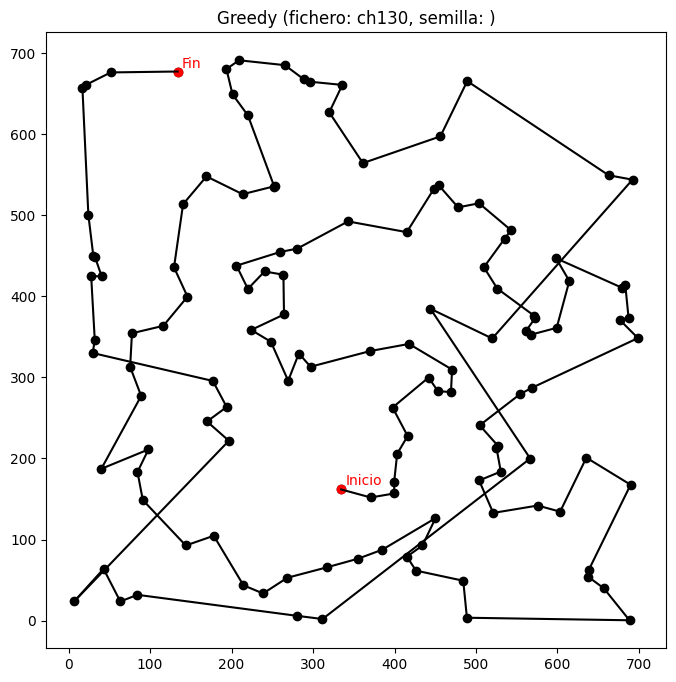

Mejor camino:  [0, 40, 38, 70, 129, 49, 1, 117, 79, 45, 19, 34, 53, 16, 30, 33, 26, 18, 99, 115, 23, 14, 28, 94, 78, 37, 105, 57, 48, 52, 119, 59, 50, 41, 43, 39, 46, 36, 21, 22, 121, 54, 13, 9, 66, 95, 12, 32, 20, 17, 7, 107, 113, 2, 82, 29, 58, 120, 77, 89, 124, 84, 65, 27, 114, 61, 104, 111, 116, 127, 15, 44, 75, 108, 60, 128, 123, 25, 96, 69, 6, 62, 67, 97, 109, 88, 93, 76, 102, 80, 11, 86, 64, 55, 56, 8, 51, 74, 73, 98, 72, 91, 71, 90, 5, 101, 92, 3, 125, 4, 10, 63, 68, 87, 85, 126, 106, 103, 42, 47, 24, 31, 112, 35, 83, 118, 110, 122, 100, 81] 
 Distancia recorrida: 7026


In [13]:
fichero_name = "ch130"
fichero = 'tsp/' + fichero_name + '.tsp'
datos_ciudades = cargar_datos(fichero)
distancias = calcular_distancias(datos_ciudades)
path, coste_greedy_c130, _, _ = greedy(datos_ciudades, distancias)

representar_mapa(datos_ciudades, path, greedy_name, fichero_name)

print("Mejor camino: ", path, "\n", "Distancia recorrida:", coste_greedy_c130)

### a280

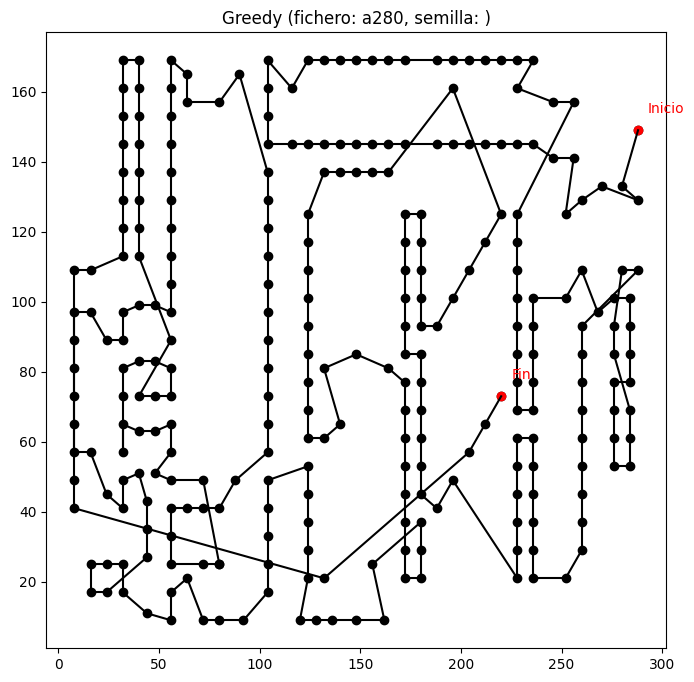

Mejor camino:  [0, 279, 1, 2, 278, 277, 3, 276, 275, 274, 273, 272, 271, 270, 15, 16, 17, 18, 19, 20, 127, 126, 125, 124, 29, 30, 31, 28, 27, 26, 25, 21, 24, 22, 23, 13, 12, 11, 10, 9, 7, 6, 8, 5, 4, 259, 258, 257, 256, 253, 252, 207, 206, 209, 208, 251, 254, 255, 248, 247, 246, 243, 240, 239, 238, 237, 230, 231, 232, 233, 234, 235, 236, 245, 244, 242, 241, 249, 250, 229, 228, 227, 226, 225, 224, 223, 222, 221, 218, 217, 214, 213, 210, 211, 212, 215, 216, 219, 220, 202, 201, 199, 143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 269, 268, 267, 266, 265, 264, 263, 262, 261, 260, 14, 132, 131, 130, 129, 128, 153, 154, 152, 155, 151, 150, 176, 175, 180, 179, 178, 177, 149, 148, 147, 146, 145, 144, 198, 197, 196, 193, 194, 195, 200, 192, 191, 190, 189, 188, 187, 186, 184, 183, 182, 181, 160, 161, 162, 163, 164, 165, 166, 167, 168, 100, 99, 98, 97, 92, 93, 94, 95, 96, 91, 90, 89, 88, 80, 79, 78, 75, 74, 73, 72, 71, 70, 69, 66, 65, 64, 63, 62, 61, 117, 60, 59, 42, 41, 40, 39, 38, 37, 36

In [14]:
fichero_name = "a280"
fichero = 'tsp/' + fichero_name + '.tsp'
datos_ciudades = cargar_datos(fichero)
distancias = calcular_distancias(datos_ciudades)
path, coste_greedy_a280, _, _ = greedy(datos_ciudades, distancias)

representar_mapa(datos_ciudades, path, greedy_name, fichero_name)

print("Mejor camino: ", path, "\n", "Distancia recorrida:", coste_greedy_a280)

## Algoritmos de Hurísticas No Constructivas

### Sistema de Hormigas

In [15]:
def sistema_hormigas(datos_ciudades, distancias, num_hormigas = 30, tiempo_limite = 60, alpha = 1, beta = 2, rho = 0.1, f0 = 1):
    num_ciudades = len(datos_ciudades)
    path_optimo = None
    coste_optimo = float("inf")

    # Inicializar feromonas a valor inicial
    feromonas = np.ones((num_ciudades, num_ciudades)) * f0 / num_ciudades
    evaluaciones = 0

    tiempo_limite = float(tiempo_limite)
    tiempo_ejecucion_segundos= 0.0

    barra_progreso = tqdm(total=tiempo_limite, leave=True, unit='s')  # Creamos la barra de progreso

    while tiempo_ejecucion_segundos < tiempo_limite:
        tiempo_inicio = time.time()

        # Crear colonia de hormigas
        hormigas = []
        for j in range(num_hormigas):
            #ciudad_inicial = int(random.randint(0, num_ciudades-1))
            #hormigas.append([ciudad_inicial])

            # Si queremos empezar por la ciudad 0: todas las hormigas a la ciudad 0 en el inicio:
            hormigas.append([0])

        # Recorrer todas las ciudades
        for hormiga in hormigas:
            ciudades_visitadas = set(hormiga)
            while len(ciudades_visitadas) < num_ciudades:
                ciudad_actual = hormiga[-1]
                probabilidad = []
                for ciudad in range(num_ciudades):
                    if ciudad not in ciudades_visitadas:
                        feromona = feromonas[ciudad_actual][ciudad]
                        distancia = distancias[ciudad_actual][ciudad]
                        if distancia != 0:
                            probabilidad.append((ciudad, feromona**alpha * (1.0/distancia)**beta))
                        else:
                            probabilidad.append((ciudad, 0))
                probabilidad = np.array(probabilidad)
                probabilidad[:, 1] = probabilidad[:, 1] / np.sum(probabilidad[:, 1])
                siguiente_ciudad = int(np.random.choice(probabilidad[:, 0], p=probabilidad[:, 1]))
                hormiga.append(siguiente_ciudad)
                ciudades_visitadas.add(siguiente_ciudad)

        # Calcular coste y actualizar mejor solución
        for hormiga in hormigas:
            coste = coste_camino(hormiga, distancias)
            evaluaciones += 1
            if coste < coste_optimo:
                path_optimo = hormiga
                coste_optimo = coste

        # Actualizar feromonas
        feromonas *= (1 - rho)
        for hormiga in hormigas:
            for i in range(len(hormiga)-1):
                ciudad1 = hormiga[i]
                ciudad2 = hormiga[i+1]
                # Solo se actualiza la feromona de la hormiga que haya encontrado la mejor solución
                if coste_camino(hormiga, distancias) == coste_optimo:
                    feromonas[ciudad1, ciudad2] += 1.0 / coste_optimo

        tiempo_fin = time.time()
        tiempo_elapsado = tiempo_fin - tiempo_inicio
        tiempo_ejecucion_segundos += tiempo_elapsado

        # Mostrar barra de progreso
        barra_progreso.update(round(tiempo_elapsado))

    barra_progreso.close()

    return path_optimo, coste_optimo, evaluaciones, round(tiempo_ejecucion_segundos,2)

In [16]:
'''fichero_name = "ch130"
fichero = 'tsp/' + fichero_name + '.tsp'
datos_ciudades = cargar_datos(fichero)
distancias = calcular_distancias(datos_ciudades)

num_hormigas = n_hormigas
tiempo_limite = tiempo_max_c130
a = alpha
b = beta
rho = parametro_evaporacion

n = len(datos_ciudades)
L = coste_greedy_c130
cantidad_feronoma_0 = 1 / (n * L)

f0 = cantidad_feronoma_0

path_optimo, coste_optimo, evaluaciones, tiempo_ejecucion_segundos = sistema_hormigas(datos_ciudades, distancias, num_hormigas, tiempo_limite, a, b, rho, f0)

print("El camino óptimo es:", path_optimo)
print("El coste óptimo es:", coste_optimo)
print("El número de evaluaciones es:", evaluaciones)
print("El tiempo de ejecución es:", tiempo_ejecucion_segundos, " segundos")
representar_mapa(datos_ciudades, path_optimo, algorithm_name=sh_name, fichero_name=fichero_name)'''

'fichero_name = "ch130"\nfichero = \'tsp/\' + fichero_name + \'.tsp\'\ndatos_ciudades = cargar_datos(fichero)\ndistancias = calcular_distancias(datos_ciudades)\n\nnum_hormigas = n_hormigas\ntiempo_limite = tiempo_max_c130\na = alpha\nb = beta\nrho = parametro_evaporacion\n\nn = len(datos_ciudades)\nL = coste_greedy_c130\ncantidad_feronoma_0 = 1 / (n * L)\n\nf0 = cantidad_feronoma_0\n\npath_optimo, coste_optimo, evaluaciones, tiempo_ejecucion_segundos = sistema_hormigas(datos_ciudades, distancias, num_hormigas, tiempo_limite, a, b, rho, f0)\n\nprint("El camino óptimo es:", path_optimo)\nprint("El coste óptimo es:", coste_optimo)\nprint("El número de evaluaciones es:", evaluaciones)\nprint("El tiempo de ejecución es:", tiempo_ejecucion_segundos, " segundos")\nrepresentar_mapa(datos_ciudades, path_optimo, algorithm_name=sh_name, fichero_name=fichero_name)'

In [17]:
'''fichero_name = "a280"
fichero = 'tsp/' + fichero_name + '.tsp'
datos_ciudades = cargar_datos(fichero)
distancias = calcular_distancias(datos_ciudades)

num_hormigas = n_hormigas
tiempo_limite = tiempo_max_a280
a = alpha
b = beta
rho = parametro_evaporacion

n = len(datos_ciudades)
L = coste_greedy_c130
cantidad_feronoma_0 = 1 / (n * L)

f0 = cantidad_feronoma_0

path_optimo, coste_optimo, evaluaciones, tiempo_ejecucion_segundos = sistema_hormigas(datos_ciudades, distancias, num_hormigas, tiempo_limite, a, b, rho, f0)

print("El camino óptimo es:", path_optimo)
print("El coste óptimo es:", coste_optimo)
print("El número de evaluaciones es:", evaluaciones)
print("El tiempo de ejecución es:", tiempo_ejecucion_segundos)
representar_mapa(datos_ciudades, path_optimo, algorithm_name=sh_name, fichero_name=fichero_name)'''

'fichero_name = "a280"\nfichero = \'tsp/\' + fichero_name + \'.tsp\'\ndatos_ciudades = cargar_datos(fichero)\ndistancias = calcular_distancias(datos_ciudades)\n\nnum_hormigas = n_hormigas\ntiempo_limite = tiempo_max_a280\na = alpha\nb = beta\nrho = parametro_evaporacion\n\nn = len(datos_ciudades)\nL = coste_greedy_c130\ncantidad_feronoma_0 = 1 / (n * L)\n\nf0 = cantidad_feronoma_0\n\npath_optimo, coste_optimo, evaluaciones, tiempo_ejecucion_segundos = sistema_hormigas(datos_ciudades, distancias, num_hormigas, tiempo_limite, a, b, rho, f0)\n\nprint("El camino óptimo es:", path_optimo)\nprint("El coste óptimo es:", coste_optimo)\nprint("El número de evaluaciones es:", evaluaciones)\nprint("El tiempo de ejecución es:", tiempo_ejecucion_segundos)\nrepresentar_mapa(datos_ciudades, path_optimo, algorithm_name=sh_name, fichero_name=fichero_name)'

### Sistema de Hormigas Elitista

In [18]:
def sistema_hormigas_elitista(datos_ciudades, distancias, num_hormigas = 30, tiempo_limite = 60, alpha = 1, beta = 2, rho = 0.1, f0 = 1, n_elitistas = 15):
    num_ciudades = len(datos_ciudades)
    path_optimo = None
    coste_optimo = float("inf")
    path_elitista = None
    coste_elitista = float("inf")

    # Inicializar feromonas a valor inicial
    feromonas = np.ones((num_ciudades, num_ciudades)) * f0 / num_ciudades
    evaluaciones = 0

    tiempo_limite = float(tiempo_limite)
    tiempo_ejecucion_segundos= 0.0

    barra_progreso = tqdm(total=tiempo_limite, leave=True, unit='s')  # Creamos la barra de progreso

    while tiempo_ejecucion_segundos < tiempo_limite:
        tiempo_inicio = time.time()

        # Crear colonia de hormigas
        hormigas = []
        for j in range(num_hormigas):
            hormigas.append([0]) # Empezamos todas en la ciudad 0

        # Recorrer todas las ciudades
        for hormiga in hormigas:
            ciudades_visitadas = set(hormiga)
            while len(ciudades_visitadas) < num_ciudades:
                ciudad_actual = hormiga[-1]
                probabilidad = []
                for ciudad in range(num_ciudades):
                    if ciudad not in ciudades_visitadas:
                        feromona = feromonas[ciudad_actual][ciudad]
                        distancia = distancias[ciudad_actual][ciudad]
                        if distancia != 0:
                            probabilidad.append((ciudad, feromona**alpha * (1.0/distancia)**beta))
                        else:
                            probabilidad.append((ciudad, 0))
                probabilidad = np.array(probabilidad)
                probabilidad[:, 1] = probabilidad[:, 1] / np.sum(probabilidad[:, 1])
                siguiente_ciudad = int(np.random.choice(probabilidad[:, 0], p=probabilidad[:, 1]))
                hormiga.append(siguiente_ciudad)
                ciudades_visitadas.add(siguiente_ciudad)

        # Ordenar hormigas por coste y seleccionar las n_elitistas mejores
        hormigas.sort(key=lambda x: coste_camino(x, distancias))
        hormigas_elitistas = hormigas[:n_elitistas]

        # Calcular coste y actualizar mejor solución
        for hormiga in hormigas:
            coste = coste_camino(hormiga, distancias)
            evaluaciones += 1
            if coste < coste_optimo:
                path_optimo = hormiga
                coste_optimo = coste
            elif coste < coste_elitista:
                path_elitista = hormiga
                coste_elitista = coste

        # Actualizar feromonas
        feromonas *= (1 - rho)
        if path_elitista is not None:
            for i in range(len(path_elitista)-1):
                ciudad1 = path_elitista[i]
                ciudad2 = path_elitista[i+1]
                feromonas[ciudad1, ciudad2] += n_elitistas / coste_elitista

        # Actualizar feromonas para las hormigas elitistas
        num_elitistas = n_elitistas if n_elitistas <= num_hormigas else num_hormigas
        idx_elitistas = np.argsort([coste_camino(hormiga, distancias) for hormiga in hormigas])[:num_elitistas]
        for idx in idx_elitistas:
            hormiga = hormigas[idx]
            for i in range(len(hormiga) - 1):
                ciudad1 = hormiga[i]
                ciudad2 = hormiga[i + 1]
                feromonas[ciudad1, ciudad2] += 1.0 / coste_optimo

        tiempo_fin = time.time()
        tiempo_elapsado = tiempo_fin - tiempo_inicio
        tiempo_ejecucion_segundos += tiempo_elapsado

        # Mostrar barra de progreso
        barra_progreso.update(round(tiempo_elapsado))

    barra_progreso.close()

    return path_optimo, coste_optimo, evaluaciones, round(tiempo_ejecucion_segundos, 2)

In [19]:
'''fichero_name = "ch130"
fichero = 'tsp/' + fichero_name + '.tsp'
datos_ciudades = cargar_datos(fichero)
distancias = calcular_distancias(datos_ciudades)

num_hormigas = n_hormigas
tiempo_limite = tiempo_max_c130
a = alpha
b = beta
rho = parametro_evaporacion

n = len(datos_ciudades)
L = coste_greedy_c130
cantidad_feronoma_0 = 1 / (n * L)

f0 = cantidad_feronoma_0

path_optimo, coste_optimo, evaluaciones, tiempo_ejecucion_segundos = sistema_hormigas_elitista(datos_ciudades, distancias, num_hormigas, tiempo_limite, a, b, rho, f0)

print("El camino óptimo es:", path_optimo)
print("El coste óptimo es:", coste_optimo)
print("El número de evaluaciones es:", evaluaciones)
print("El tiempo de ejecución es:", tiempo_ejecucion_segundos, " segundos")
representar_mapa(datos_ciudades, path_optimo, algorithm_name=sh_name, fichero_name=fichero_name)'''

'fichero_name = "ch130"\nfichero = \'tsp/\' + fichero_name + \'.tsp\'\ndatos_ciudades = cargar_datos(fichero)\ndistancias = calcular_distancias(datos_ciudades)\n\nnum_hormigas = n_hormigas\ntiempo_limite = tiempo_max_c130\na = alpha\nb = beta\nrho = parametro_evaporacion\n\nn = len(datos_ciudades)\nL = coste_greedy_c130\ncantidad_feronoma_0 = 1 / (n * L)\n\nf0 = cantidad_feronoma_0\n\npath_optimo, coste_optimo, evaluaciones, tiempo_ejecucion_segundos = sistema_hormigas_elitista(datos_ciudades, distancias, num_hormigas, tiempo_limite, a, b, rho, f0)\n\nprint("El camino óptimo es:", path_optimo)\nprint("El coste óptimo es:", coste_optimo)\nprint("El número de evaluaciones es:", evaluaciones)\nprint("El tiempo de ejecución es:", tiempo_ejecucion_segundos, " segundos")\nrepresentar_mapa(datos_ciudades, path_optimo, algorithm_name=sh_name, fichero_name=fichero_name)'

In [20]:
def comparar_algoritmos(fichero_name, semillas, num_hormigas=30, tiempo_limite=60, alpha=1, beta=2, rho=0.1, f0=1, n_elitistas=15):
    # Cargar datos y calcular distancias
    fichero = 'tsp/' + fichero_name + '.tsp'
    datos_ciudades = cargar_datos(fichero)
    distancias = calcular_distancias(datos_ciudades)

    # Definir algoritmos
    algoritmos = [('Greedy', greedy, []),
                  ('Sistema de Hormigas', sistema_hormigas, [num_hormigas, tiempo_limite, alpha, beta, rho, f0]),
                  ('Sistema de Hormigas Elitista', sistema_hormigas_elitista, [num_hormigas, tiempo_limite, alpha, beta, rho, f0, n_elitistas])]

    # Ejecutar algoritmos para cada semilla
    resultados = []
    for semilla in semillas:
        random.seed(semilla)
        res_semilla = []
        for algoritmo_name, algoritmo, algoritmo_params in algoritmos:
            # Ejecutar algoritmo y guardar coste y evaluaciones
            params = (datos_ciudades, distancias) + tuple(algoritmo_params)
            path_optimo, coste_optimo, evaluaciones, tiempo_ejecucion_segundos = algoritmo(*params)
            res_semilla.append((tiempo_ejecucion_segundos, evaluaciones, coste_optimo))

            representar_mapa(datos_ciudades, path_optimo, algorithm_name=sh_name, fichero_name=fichero_name, semilla = semilla)
            print("El camino óptimo es:", path_optimo)
            print("El coste óptimo es:", coste_optimo)
            print("El número de evaluaciones es:", evaluaciones)
            print("El tiempo de ejecución es:", tiempo_ejecucion_segundos, " segundos")
            print("\n\n")
            print("=========================================================================================================")
            print("\n\n")

        resultados.append(res_semilla)

    print("\n\n\n\n\n\n")

    # Crear tabla de resultados
    header = ('', 'Caso 1', '', 'Caso 2', '', 'Caso 3', '')
    subheader = ('Ejecución', 'Coste', 'Sol. Ópt', 'Ev.', 'Coste', 'Sol. Ópt', 'Ev.', 'Coste', 'Ev.', 'Sol. Ópt')
    tabla = [header, subheader]
    for i, res in enumerate(resultados):
        fila = [f'Ejecución {i+1}']
        for tiempo_ejecucion_segundos, evaluaciones, coste in res:
            fila.append(f'{tiempo_ejecucion_segundos:.2f}')
            fila.append(str(evaluaciones))
            fila.append(f'{coste:.2f}')
        tabla.append(fila)

    # Calcular la media y desviación típica
    resultados_np = np.array(resultados)
    media = np.mean(resultados_np, axis=0)
    desviacion = np.std(resultados_np, axis=0)

    # Agregar filas a la tabla de resultados
    media_str = ['Media'] + [f'{c:.3f}' for c in media.flatten()]
    desviacion_str = ['Desv. típica'] + [f'{c:.3f}' for c in desviacion.flatten()]
    tabla.append(media_str)
    tabla.append(desviacion_str)

    # Imprimir tabla
    for fila in tabla:
        print('{:^12}'.format(fila[0]), end='|')
        for elem in fila[1:]:
            print('{:^10}'.format(elem), end='|')
        print()


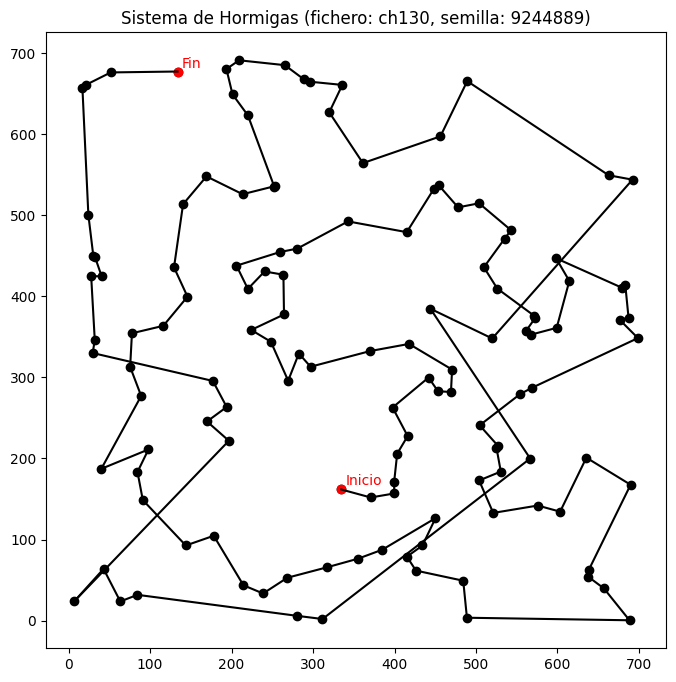

El camino óptimo es: [0, 40, 38, 70, 129, 49, 1, 117, 79, 45, 19, 34, 53, 16, 30, 33, 26, 18, 99, 115, 23, 14, 28, 94, 78, 37, 105, 57, 48, 52, 119, 59, 50, 41, 43, 39, 46, 36, 21, 22, 121, 54, 13, 9, 66, 95, 12, 32, 20, 17, 7, 107, 113, 2, 82, 29, 58, 120, 77, 89, 124, 84, 65, 27, 114, 61, 104, 111, 116, 127, 15, 44, 75, 108, 60, 128, 123, 25, 96, 69, 6, 62, 67, 97, 109, 88, 93, 76, 102, 80, 11, 86, 64, 55, 56, 8, 51, 74, 73, 98, 72, 91, 71, 90, 5, 101, 92, 3, 125, 4, 10, 63, 68, 87, 85, 126, 106, 103, 42, 47, 24, 31, 112, 35, 83, 118, 110, 122, 100, 81]
El coste óptimo es: 7026
El número de evaluaciones es: 528
El tiempo de ejecución es: 0.0009970664978027344  segundos








  6%|▌         | 11/180.0 [00:09<02:47,  1.01s/s]

In [ ]:
fichero_name = "ch130"
fichero = 'tsp/' + fichero_name + '.tsp'
datos_ciudades = cargar_datos(fichero)
distancias = calcular_distancias(datos_ciudades)

num_hormigas = n_hormigas
tiempo_limite = tiempo_max_c130
a = alpha
b = beta
rho = parametro_evaporacion

n = len(datos_ciudades)
L = coste_greedy_c130
cantidad_feronoma_0 = 1 / (n * L)

f0 = cantidad_feronoma_0

tam_elite = n_elitistas

comparar_algoritmos(fichero_name, semillas, num_hormigas=num_hormigas, tiempo_limite=tiempo_limite, alpha=a, beta=b, rho=rho, f0=cantidad_feronoma_0, n_elitistas=tam_elite)